In [1]:
from fytok.Tokamak import Tokamak

2023-11-17 15:05:17,431 [   fytok]     INFO: 
#######################################################################################################################
    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = develop  (spdm=develop extension=0.2.2.dev11+g706f667, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-11-17T15:05:17.431802.
 Job ID: fytok_salmon_surface_18263

#######################################################################################################################



In [2]:
tok = Tokamak("mdsplus:///home/salmon/workspace/fytok_data/mdsplus/~t/?enable=efit_east", device="east", shot=70754)

2023-11-17 15:05:17,568 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_xml


In [3]:
limiter=tok.wall.description_2d[0].limiter
limiter.unit

In [4]:
tok.refresh(time=5.0)

2023-11-17 15:05:17,985 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.fy_eq
2023-11-17 15:05:18,126 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_mdsplus
2023-11-17 15:05:18,127 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/plugins/data/plugin_mdsplus.py:118:get_tree: Open MDSplus Tree [efit_east] shot=70754
2023-11-17 15:05:18,160 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.transport_solver_numerics.fy_trans


2023-11-17 15:05:18,174 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.view.view_matplotlib
2023-11-17 15:05:18,341 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.mesh.mesh_rectangular


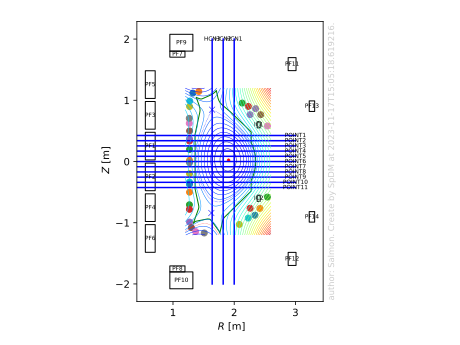

In [5]:
tok

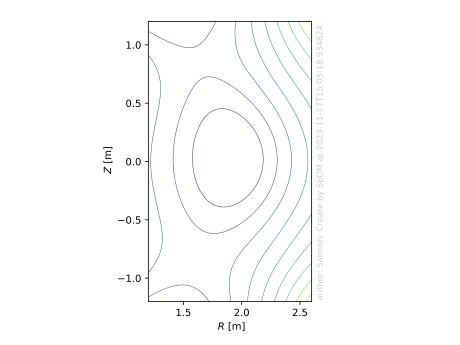

In [6]:
tok.equilibrium.time_slice.current.profiles_2d.psi

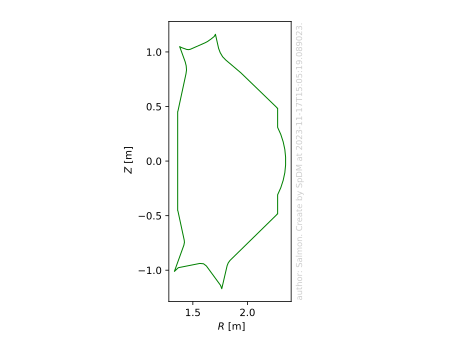

In [7]:
tok.wall

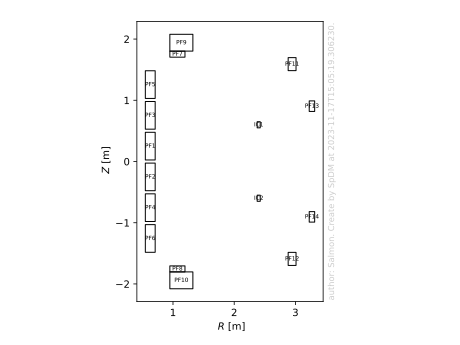

In [8]:
tok.pf_active

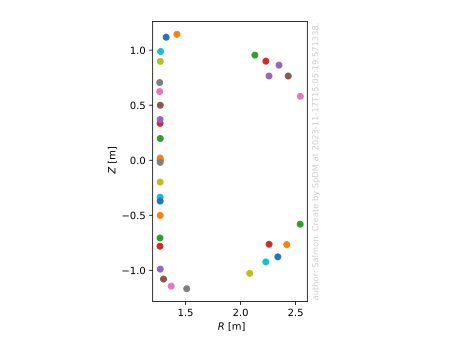

In [9]:
tok.magnetics

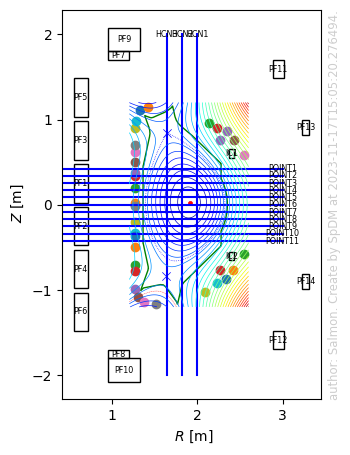

In [10]:
from spdm.view import View as sp_view

fig=sp_view.display(tok.__geometry__(view="top"))